# SEM REAMOSTRAGEM



In [ ]:
import os
import sys
import csv
import numpy as np
import pandas as pd
from encoders import process_input, ThermometerEncoder, CodeWord
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from typing import List, Dict

# Implementação das classes RAM, Discriminator, Bleaching e WiSARD
class RAM:
    def __init__(self, indexes: List[int] = None):
        self.addresses = indexes if indexes else []
        self.positions: Dict[int, int] = {}

    def get_vote(self, input_data: List[int]) -> int:
        index = self.get_index(input_data)
        return self.positions.get(index, 0)

    def train(self, input_data: List[int]):
        index = self.get_index(input_data)
        self.positions[index] = self.positions.get(index, 0) + 1

    def get_index(self, input_data: List[int]) -> int:
        index = 0
        p = 1
        for addr in self.addresses:
            bit = input_data[addr]
            index += bit * p
            p *= 2
        return index

class Discriminator:
    def __init__(self, address_size: int, entry_size: int):
        self.entry_size = entry_size
        self.rams: List[RAM] = []
        self.set_ram_shuffle(address_size)

    def classify(self, input_data: List[int]) -> List[int]:
        return [ram.get_vote(input_data) for ram in self.rams]

    def train(self, input_data: List[int]):
        for ram in self.rams:
            ram.train(input_data)

    def set_ram_shuffle(self, address_size: int):
        num_rams = self.entry_size // address_size
        remain = self.entry_size % address_size
        indexes = list(range(self.entry_size))
        np.random.shuffle(indexes)

        self.rams = []
        for i in range(num_rams):
            sub_indexes = indexes[i * address_size:(i + 1) * address_size]
            self.rams.append(RAM(sub_indexes))

class Bleaching:
    @staticmethod
    def make(all_votes: List[List[int]]) -> List[int]:
        labels = [0, 0]
        bleaching = 1
        while True:
            for i in range(2):
                labels[i] = sum(1 for vote in all_votes[i] if vote >= bleaching)
            bleaching += 1
            biggest = max(labels)
            if labels.count(biggest) == 1 or biggest <= 1:
                break
        return labels

class WiSARD:
    def __init__(self, address_size: int, input_size: int):
        self.address_size = address_size
        self.discriminators = [
            Discriminator(address_size, input_size),
            Discriminator(address_size, input_size)
        ]

    def train(self, input_data: List[int], label: int):
        self.discriminators[label].train(input_data)

    def classify(self, input_data: List[int]) -> int:
        candidates = self.classify2(input_data)
        return 0 if candidates[0] >= candidates[1] else 1

    def classify2(self, input_data: List[int]) -> List[int]:
        all_votes = [
            self.discriminators[0].classify(input_data),
            self.discriminators[1].classify(input_data)
        ]
        return Bleaching.make(all_votes)

# Função para binarizar o dataset
def binarize_column(column_name, value):
    #Função para realizar a binarização de acordo com o valor da coluna.
    if column_name == "Gender":
        return "10" if value == "Male" else "01"
    elif column_name == "Age":
        thermometer = ThermometerEncoder(minimum=18, maximum=59, resolution=4)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "Profession":
        if value == "Architect":
            return "1000000000000000"
        elif value == "Chef":
            return "0100000000000000"
        elif value == "Civil Engineer":
            return "0010000000000000"
        elif value == "Content Writer":
            return "0001000000000000"
        elif value == "Civil Engineer":
            return "0000100000000000"
        elif value == "Digital Marketer":
            return "0000010000000000"
        elif value == "Doctor":
            return "0000001000000000"
        elif value == "Civil Engineer":
            return "0000000100000000"
        elif value == "Educational Consultant":
            return "0000000010000000"
        elif value == "Entrepreneur":
            return "0000000001000000"
        elif value == "Lawyer":
            return "0000000000100000"
        elif value == "Manager":
            return "0000000000010000"
        elif value == "Pharmacist":
            return "0000000000001000"
        elif value == "Student":
            return "0000000000000100"
        elif value == "Teacher":
            return "0000000000000010"
        elif value == "UX/UI Designer":
            return "0000000000000001"
    elif column_name == "AcademicPressure":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "WorkPressure":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=4)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "GPA":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=10.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "StudySatisfaction":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=3)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "JobSatisfaction":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=4.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "SleepDuration":
        if value == "5-6 hours":
            return "0100"  # Menor ênfase
        elif value == "Less than 5 hours":
            return "1110"  # Maior ênfase para pouco sono
        elif value == "7-8 hours":
            return "0010"  # Menor ênfase (normal)
        elif value == "More than 8 hours":
            return "0111"  # Maior ênfase para muito sono
    elif column_name == "DietaryHabits":
        if value == "Healthy":
            return "0100"
        elif value == "Unhealthy":
            return "1110"
        elif value == "Moderate":
            return "0010"
        elif value == "Others":
            return "0001"
    elif column_name == "SuicidalThoughts":
        if value == "Yes":
            return "111111111111"
        elif value == "No":
            return "000000000000"
    elif column_name == "WorkStudyHours":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=12.0, resolution=10)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "FinancialsStress":
        thermometer = ThermometerEncoder(minimum=1.0, maximum=5.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "FamilyMentalIllness":
        if str(value) == "Yes":
            return "111111111111"
        elif str(value) == "No":
            return "000000000000"

train_data = []  # Lista para armazenar os dados binarizados
train_labels = [] # Lista para armazenar os rótulos dos dados

def binarize_dataset(input_file):
    """
    Lê um arquivo .csv, binariza cada linha e salva em um novo arquivo.
    """
    columns_to_process = [
        "Gender", "Age", "Profession", "AcademicPressure", "WorkPressure", "GPA",
        "StudySatisfaction", "JobSatisfaction", "SleepDuration", "DietaryHabits",
        "SuicidalThoughts", "WorkStudyHours", "FinancialsStress", "FamilyMentalIllness"
    ]

    # Lendo o arquivo de entrada
    df = pd.read_excel(input_file)

    # Processando as linhas
    binary_representations = []
    for _, row in df.iterrows():
        binary_representation = ""
        for column in columns_to_process:
            binary_representation += binarize_column(column, row[column])
        train_data.append(list(map(int, binary_representation)))
        train_labels.append(1 if row["Depression"] == 1 else 0)  # Rótulos como inteiros

    return train_data, train_labels

# Função principal para o dataset de depressão
def main():
    # Substitua sys.argv por parâmetros diretos
    input_file = "/content/drive/MyDrive/RedesNeurais-Conteudos/TrabalhoFinal/Final_Student depression - Domingo.xlsx"  # Substitua pelo caminho do seu arquivo Excel
    train_data, train_labels = binarize_dataset(input_file)
    address_size = 10  # Substitua pelo tamanho desejado do endereço

    input_size = len(train_data[0])
    wisard = WiSARD(address_size, input_size)

    # Dividir o dataset em treino e teste usando train_test_split
    SEED = 42
    np.random.seed(SEED)
    # Divisão do dataset em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=SEED)


    # Treinamento
    for input_data, label in zip(X_train, y_train):
        wisard.train(input_data, label)

    # Teste no conjunto de teste
    y_pred = [wisard.classify(x) for x in X_test]

    # Resultados
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Teste Accuracy: {accuracy:.2%}")
    print("Teste (sem reamostragem) - Classification Report:")
    print(classification_report(y_test, y_pred))

    # Teste no conjunto de treino
    y_train_pred = [wisard.classify(x) for x in X_train]
    print("-------------------------------")
    # Métricas do conjunto de treino
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_accuracy:.2%}")
    print("Training Classification Report:")
    print(classification_report(y_train, y_train_pred))

# Execute a função diretamente
main()



Teste Accuracy: 79.52%
Teste - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.75      2336
           1       0.81      0.85      0.83      3240

    accuracy                           0.80      5576
   macro avg       0.79      0.79      0.79      5576
weighted avg       0.79      0.80      0.79      5576

Training Accuracy: 80.52%
Training Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      9218
           1       0.82      0.85      0.84     13086

    accuracy                           0.81     22304
   macro avg       0.80      0.80      0.80     22304
weighted avg       0.80      0.81      0.80     22304



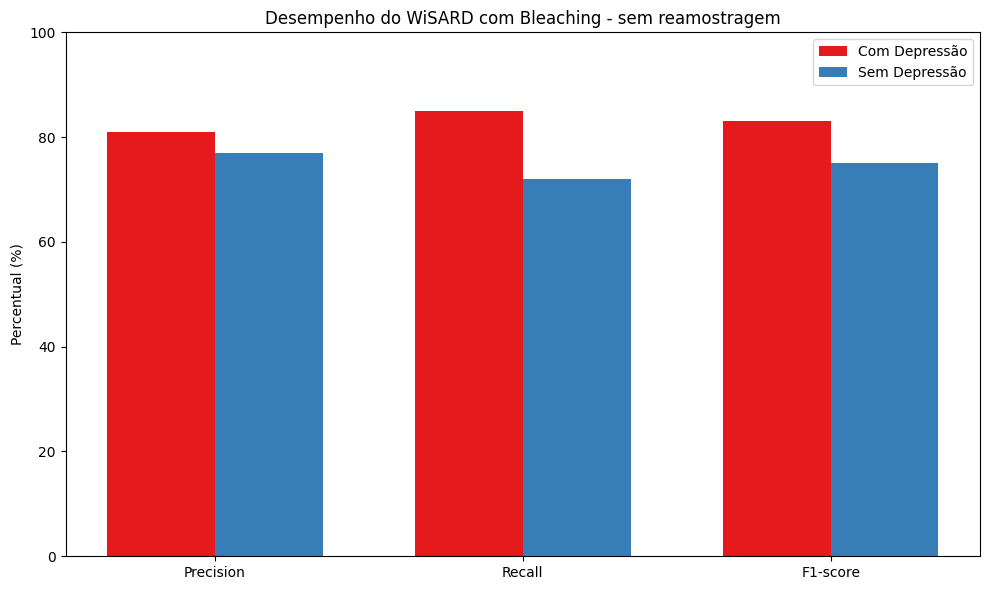

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados das métricas (sem Accuracy)
metrics = ["Precision", "Recall", "F1-score"]
values_com_depressao = [81.00, 85.00, 83.00]  # Substitua pelos valores reais
values_sem_depressao = [77.00, 72.00, 75.00]  # Substitua pelos valores reais

# Configuração do gráfico
x = np.arange(len(metrics))  # Posições no eixo X
width = 0.35  # Largura das barras

plt.figure(figsize=(10, 6))

# Plotar as barras
plt.bar(x - width/2, values_com_depressao, width, label="Com Depressão", color='#e41a1c')
plt.bar(x + width/2, values_sem_depressao, width, label="Sem Depressão", color='#377eb8')

# Personalização do gráfico
plt.title("Desempenho do WiSARD com Bleaching - sem reamostragem")
plt.ylabel("Percentual (%)")
plt.ylim(0, 100)
plt.xticks(x, metrics)
plt.legend()

# Exibir gráfico
plt.tight_layout()
plt.show()

# UTILIZANDO SUBAMOSTRAGEM

In [ ]:
import os
import sys
import csv
import numpy as np
import pandas as pd
from encoders import process_input, ThermometerEncoder, CodeWord
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from typing import List, Dict
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import warnings

# Filtrar warnings de futuros relacionados ao scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# Implementação das classes RAM, Discriminator, Bleaching e WiSARD
class RAM:
    def __init__(self, indexes: List[int] = None):
        self.addresses = indexes if indexes else []
        self.positions: Dict[int, int] = {}

    def get_vote(self, input_data: List[int]) -> int:
        index = self.get_index(input_data)
        return self.positions.get(index, 0)

    def train(self, input_data: List[int]):
        index = self.get_index(input_data)
        self.positions[index] = self.positions.get(index, 0) + 1

    def get_index(self, input_data: List[int]) -> int:
        index = 0
        p = 1
        for addr in self.addresses:
            bit = input_data[addr]
            index += bit * p
            p *= 2
        return index

class Discriminator:
    def __init__(self, address_size: int, entry_size: int):
        self.entry_size = entry_size
        self.rams: List[RAM] = []
        self.set_ram_shuffle(address_size)

    def classify(self, input_data: List[int]) -> List[int]:
        return [ram.get_vote(input_data) for ram in self.rams]

    def train(self, input_data: List[int]):
        for ram in self.rams:
            ram.train(input_data)

    def set_ram_shuffle(self, address_size: int):
        num_rams = self.entry_size // address_size
        remain = self.entry_size % address_size
        indexes = list(range(self.entry_size))
        np.random.shuffle(indexes)

        self.rams = []
        for i in range(num_rams):
            sub_indexes = indexes[i * address_size:(i + 1) * address_size]
            self.rams.append(RAM(sub_indexes))

class Bleaching:
    @staticmethod
    def make(all_votes: List[List[int]]) -> List[int]:
        labels = [0, 0]
        bleaching = 1
        while True:
            for i in range(2):
                labels[i] = sum(1 for vote in all_votes[i] if vote >= bleaching)
            bleaching += 1
            biggest = max(labels)
            if labels.count(biggest) == 1 or biggest <= 1:
                break
        return labels

class WiSARD:
    def __init__(self, address_size: int, input_size: int):
        self.address_size = address_size
        self.discriminators = [
            Discriminator(address_size, input_size),
            Discriminator(address_size, input_size)
        ]

    def train(self, input_data: List[int], label: int):
        self.discriminators[label].train(input_data)

    def classify(self, input_data: List[int]) -> int:
        candidates = self.classify2(input_data)
        return 0 if candidates[0] >= candidates[1] else 1

    def classify2(self, input_data: List[int]) -> List[int]:
        all_votes = [
            self.discriminators[0].classify(input_data),
            self.discriminators[1].classify(input_data)
        ]
        return Bleaching.make(all_votes)

# Função para binarizar o dataset
def binarize_column(column_name, value):
    #Função para realizar a binarização de acordo com o valor da coluna.
    if column_name == "Gender":
        return "10" if value == "Male" else "01"
    elif column_name == "Age":
        thermometer = ThermometerEncoder(minimum=18, maximum=59, resolution=4)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "Profession":
        if value == "Architect":
            return "1000000000000000"
        elif value == "Chef":
            return "0100000000000000"
        elif value == "Civil Engineer":
            return "0010000000000000"
        elif value == "Content Writer":
            return "0001000000000000"
        elif value == "Civil Engineer":
            return "0000100000000000"
        elif value == "Digital Marketer":
            return "0000010000000000"
        elif value == "Doctor":
            return "0000001000000000"
        elif value == "Civil Engineer":
            return "0000000100000000"
        elif value == "Educational Consultant":
            return "0000000010000000"
        elif value == "Entrepreneur":
            return "0000000001000000"
        elif value == "Lawyer":
            return "0000000000100000"
        elif value == "Manager":
            return "0000000000010000"
        elif value == "Pharmacist":
            return "0000000000001000"
        elif value == "Student":
            return "0000000000000100"
        elif value == "Teacher":
            return "0000000000000010"
        elif value == "UX/UI Designer":
            return "0000000000000001"
    elif column_name == "AcademicPressure":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "WorkPressure":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=4)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "GPA":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=10.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "StudySatisfaction":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=3)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "JobSatisfaction":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=4.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "SleepDuration":
        if value == "5-6 hours":
            return "0100"  # Menor ênfase
        elif value == "Less than 5 hours":
            return "1110"  # Maior ênfase para pouco sono
        elif value == "7-8 hours":
            return "0010"  # Menor ênfase (normal)
        elif value == "More than 8 hours":
            return "0111"  # Maior ênfase para muito sono
    elif column_name == "DietaryHabits":
        if value == "Healthy":
            return "0100"
        elif value == "Unhealthy":
            return "1110"
        elif value == "Moderate":
            return "0010"
        elif value == "Others":
            return "0001"
    elif column_name == "SuicidalThoughts":
        if value == "Yes":
            return "111111111111"
        elif value == "No":
            return "000000000000"
    elif column_name == "WorkStudyHours":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=12.0, resolution=10)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "FinancialsStress":
        thermometer = ThermometerEncoder(minimum=1.0, maximum=5.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "FamilyMentalIllness":
        if str(value) == "Yes":
            return "111111111111"
        elif str(value) == "No":
            return "000000000000"

train_data = []  # Lista para armazenar os dados binarizados
train_labels = [] # Lista para armazenar os rótulos dos dados

def binarize_dataset(input_file):
    """
    Lê um arquivo .csv, binariza cada linha e salva em um novo arquivo.
    """
    # Colunas que queremos processar
    columns_to_process = [
        "Gender", "Age", "Profession", "AcademicPressure", "WorkPressure", "GPA",
        "StudySatisfaction", "JobSatisfaction", "SleepDuration", "DietaryHabits",
        "SuicidalThoughts", "WorkStudyHours", "FinancialsStress", "FamilyMentalIllness"
    ]

    # Lendo o arquivo de entrada
    df = pd.read_excel(input_file)

    # Processando as linhas
    binary_representations = []
    for _, row in df.iterrows():
        binary_representation = ""
        for column in columns_to_process:
            binary_representation += binarize_column(column, row[column])
        train_data.append(list(map(int, binary_representation)))
        train_labels.append(1 if row["Depression"] == 1 else 0)  # Rótulos como inteiros
        #train_labels.append("depressao" if row["Depression"] == 1 else "sem_depressao")  # Adiciona rótulo em formato de strings

    return train_data, train_labels

# Função principal para o dataset de depressão
def main():
    # Substitua sys.argv por parâmetros diretos
    input_file = "/content/drive/MyDrive/RedesNeurais-Conteudos/TrabalhoFinal/Final_Student depression - Domingo.xlsx"  # Substitua pelo caminho do seu arquivo Excel
    train_data, train_labels = binarize_dataset(input_file)
    address_size = 10  # Substitua pelo tamanho desejado do endereço

    input_size = len(train_data[0])
    wisard = WiSARD(address_size, input_size)

    # Dividir o dataset em treino e teste usando train_test_split
    SEED = 42
    np.random.seed(SEED)
    # Divisão do dataset em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=SEED)

    """Aqui testaremos o dataset de forma balanceada UTILIZANDO SUBAMOSTRAGEM"""
    # definindo a estratégia de sub-amostragem
    undersample = RandomUnderSampler(sampling_strategy=1)

    # aplicando a transformação de reamostragem
    X_under, Y_under = undersample.fit_resample(X_train, y_train)

    # exibindo a distribuição de classes
    print("Antes da subamostragem: ", Counter(y_train))
    # exibindo a distribuição de classes
    print("Depois da subamostragem: ", Counter(Y_under))

    # Treinamento
    for input_data, label in zip(X_under, Y_under):
        wisard.train(input_data, label)

    # Teste
    balanced_predicted_wd = [wisard.classify(x) for x in X_test]
    print("-------------------------------")
    # Cálculo das métricas
    accuracy = accuracy_score(y_test, balanced_predicted_wd)
    print(f"Teste Accuracy: {accuracy:.2%}")
    print("Teste de subamostragem - Classification Report:")
    print(classification_report(y_test, balanced_predicted_wd))

    # Teste no conjunto de treino
    y_train_pred = [wisard.classify(x) for x in X_under]
    print("-------------------------------")
    # Métricas do conjunto de treino
    train_accuracy = accuracy_score(Y_under, y_train_pred)
    print(f"Training Accuracy: {train_accuracy:.2%}")
    print("Training Classification Report:")
    print(classification_report(Y_under, y_train_pred))
# Execute a função diretamente
main()



Antes da subamostragem:  Counter({1: 13086, 0: 9218})
Depois da subamostragem:  Counter({0: 9218, 1: 9218})
-------------------------------
Teste Accuracy: 80.72%
Teste de subamostragem - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      2336
           1       0.84      0.83      0.83      3240

    accuracy                           0.81      5576
   macro avg       0.80      0.80      0.80      5576
weighted avg       0.81      0.81      0.81      5576

-------------------------------
Training Accuracy: 80.92%
Training Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      9218
           1       0.80      0.82      0.81      9218

    accuracy                           0.81     18436
   macro avg       0.81      0.81      0.81     18436
weighted avg       0.81      0.81      0.81     18436



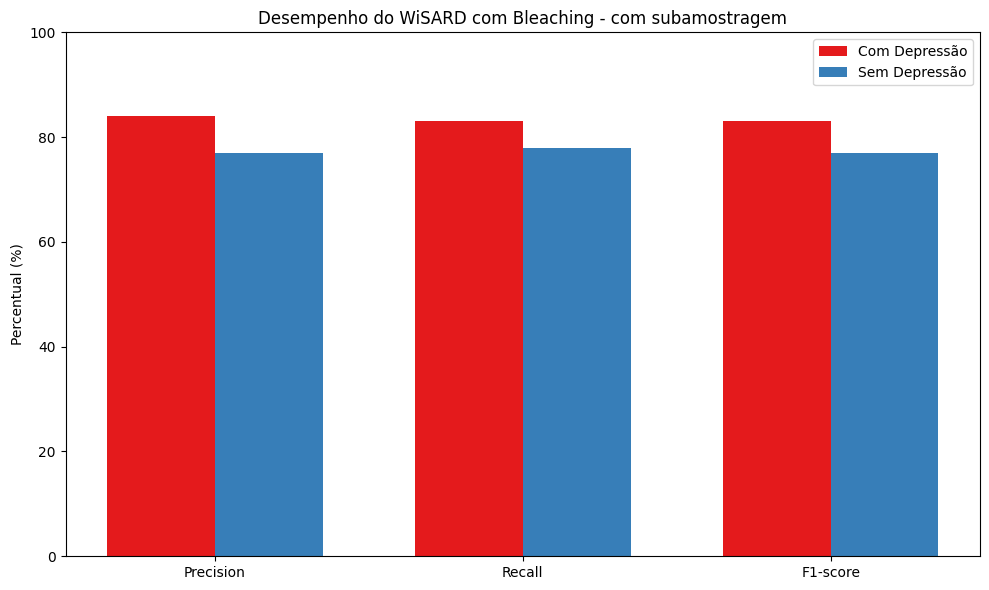

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados das métricas (sem Accuracy)
metrics = ["Precision", "Recall", "F1-score"]
values_com_depressao = [84.00, 83.00, 83.00]  # Substitua pelos valores reais
values_sem_depressao = [77.00, 78.00, 77.00] # Substitua pelos valores reais

# Configuração do gráfico
x = np.arange(len(metrics))  # Posições no eixo X
width = 0.35  # Largura das barras

plt.figure(figsize=(10, 6))

# Plotar as barras
plt.bar(x - width/2, values_com_depressao, width, label="Com Depressão", color='#e41a1c')
plt.bar(x + width/2, values_sem_depressao, width, label="Sem Depressão", color='#377eb8')

# Personalização do gráfico
plt.title("Desempenho do WiSARD com Bleaching - com subamostragem")
plt.ylabel("Percentual (%)")
plt.ylim(0, 100)
plt.xticks(x, metrics)
plt.legend()

# Exibir gráfico
plt.tight_layout()
plt.show()

# **# UTILIZANDO SUPERAMOSTRAGEM**

In [ ]:
import os
import sys
import csv
import numpy as np
import pandas as pd
from encoders import process_input, ThermometerEncoder, CodeWord
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from typing import List, Dict
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import warnings

# Filtrar warnings de futuros relacionados ao scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# Implementação das classes RAM, Discriminator, Bleaching e WiSARD
class RAM:
    def __init__(self, indexes: List[int] = None):
        self.addresses = indexes if indexes else []
        self.positions: Dict[int, int] = {}

    def get_vote(self, input_data: List[int]) -> int:
        index = self.get_index(input_data)
        return self.positions.get(index, 0)

    def train(self, input_data: List[int]):
        index = self.get_index(input_data)
        self.positions[index] = self.positions.get(index, 0) + 1

    def get_index(self, input_data: List[int]) -> int:
        index = 0
        p = 1
        for addr in self.addresses:
            bit = input_data[addr]
            index += bit * p
            p *= 2
        return index

class Discriminator:
    def __init__(self, address_size: int, entry_size: int):
        self.entry_size = entry_size
        self.rams: List[RAM] = []
        self.set_ram_shuffle(address_size)

    def classify(self, input_data: List[int]) -> List[int]:
        return [ram.get_vote(input_data) for ram in self.rams]

    def train(self, input_data: List[int]):
        for ram in self.rams:
            ram.train(input_data)

    def set_ram_shuffle(self, address_size: int):
        num_rams = self.entry_size // address_size
        remain = self.entry_size % address_size
        indexes = list(range(self.entry_size))
        np.random.shuffle(indexes)

        self.rams = []
        for i in range(num_rams):
            sub_indexes = indexes[i * address_size:(i + 1) * address_size]
            self.rams.append(RAM(sub_indexes))

class Bleaching:
    @staticmethod
    def make(all_votes: List[List[int]]) -> List[int]:
        labels = [0, 0]
        bleaching = 1
        while True:
            for i in range(2):
                labels[i] = sum(1 for vote in all_votes[i] if vote >= bleaching)
            bleaching += 1
            biggest = max(labels)
            if labels.count(biggest) == 1 or biggest <= 1:
                break
        return labels

class WiSARD:
    def __init__(self, address_size: int, input_size: int):
        self.address_size = address_size
        self.discriminators = [
            Discriminator(address_size, input_size),
            Discriminator(address_size, input_size)
        ]

    def train(self, input_data: List[int], label: int):
        self.discriminators[label].train(input_data)

    def classify(self, input_data: List[int]) -> int:
        candidates = self.classify2(input_data)
        return 0 if candidates[0] >= candidates[1] else 1

    def classify2(self, input_data: List[int]) -> List[int]:
        all_votes = [
            self.discriminators[0].classify(input_data),
            self.discriminators[1].classify(input_data)
        ]
        return Bleaching.make(all_votes)

# Função para binarizar o dataset
def binarize_column(column_name, value):
    #Função para realizar a binarização de acordo com o valor da coluna.
    if column_name == "Gender":
        return "10" if value == "Male" else "01"
    elif column_name == "Age":
        thermometer = ThermometerEncoder(minimum=18, maximum=59, resolution=4)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "Profession":
        if value == "Architect":
            return "1000000000000000"
        elif value == "Chef":
            return "0100000000000000"
        elif value == "Civil Engineer":
            return "0010000000000000"
        elif value == "Content Writer":
            return "0001000000000000"
        elif value == "Civil Engineer":
            return "0000100000000000"
        elif value == "Digital Marketer":
            return "0000010000000000"
        elif value == "Doctor":
            return "0000001000000000"
        elif value == "Civil Engineer":
            return "0000000100000000"
        elif value == "Educational Consultant":
            return "0000000010000000"
        elif value == "Entrepreneur":
            return "0000000001000000"
        elif value == "Lawyer":
            return "0000000000100000"
        elif value == "Manager":
            return "0000000000010000"
        elif value == "Pharmacist":
            return "0000000000001000"
        elif value == "Student":
            return "0000000000000100"
        elif value == "Teacher":
            return "0000000000000010"
        elif value == "UX/UI Designer":
            return "0000000000000001"
    elif column_name == "AcademicPressure":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "WorkPressure":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=4)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "GPA":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=10.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "StudySatisfaction":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=3)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "JobSatisfaction":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=4.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "SleepDuration":
        if value == "5-6 hours":
            return "0100"  # Menor ênfase
        elif value == "Less than 5 hours":
            return "1110"  # Maior ênfase para pouco sono
        elif value == "7-8 hours":
            return "0010"  # Menor ênfase (normal)
        elif value == "More than 8 hours":
            return "0111"  # Maior ênfase para muito sono
    elif column_name == "DietaryHabits":
        if value == "Healthy":
            return "0100"
        elif value == "Unhealthy":
            return "1110"
        elif value == "Moderate":
            return "0010"
        elif value == "Others":
            return "0001"
    elif column_name == "SuicidalThoughts":
        if value == "Yes":
            return "111111111111"
        elif value == "No":
            return "000000000000"
    elif column_name == "WorkStudyHours":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=12.0, resolution=10)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "FinancialsStress":
        thermometer = ThermometerEncoder(minimum=1.0, maximum=5.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "FamilyMentalIllness":
        if str(value) == "Yes":
            return "111111111111"
        elif str(value) == "No":
            return "000000000000"

train_data = []  # Lista para armazenar os dados binarizados
train_labels = [] # Lista para armazenar os rótulos dos dados

def binarize_dataset(input_file):
    """
    Lê um arquivo .csv, binariza cada linha e salva em um novo arquivo.
    """
    # Colunas que queremos processar
    columns_to_process = [
        "Gender", "Age", "Profession", "AcademicPressure", "WorkPressure", "GPA",
        "StudySatisfaction", "JobSatisfaction", "SleepDuration", "DietaryHabits",
        "SuicidalThoughts", "WorkStudyHours", "FinancialsStress", "FamilyMentalIllness"
    ]

    # Lendo o arquivo de entrada
    df = pd.read_excel(input_file)

    # Processando as linhas
    binary_representations = []
    for _, row in df.iterrows():
        binary_representation = ""
        for column in columns_to_process:
            binary_representation += binarize_column(column, row[column])
        train_data.append(list(map(int, binary_representation)))
        train_labels.append(1 if row["Depression"] == 1 else 0)  # Rótulos como inteiros
        #train_labels.append("depressao" if row["Depression"] == 1 else "sem_depressao")  # Adiciona rótulo em formato de strings

    return train_data, train_labels

# Função principal para o dataset de depressão
def main():
    # Substitua sys.argv por parâmetros diretos
    input_file = "/content/drive/MyDrive/RedesNeurais-Conteudos/TrabalhoFinal/Final_Student depression - Domingo.xlsx"  # Substitua pelo caminho do seu arquivo Excel
    train_data, train_labels = binarize_dataset(input_file)
    address_size = 10  # Substitua pelo tamanho desejado do endereço

    input_size = len(train_data[0])
    wisard = WiSARD(address_size, input_size)

    # Dividir o dataset em treino e teste usando train_test_split
    SEED = 42
    np.random.seed(SEED)
    # Divisão do dataset em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=SEED)

    """Aqui testaremos o dataset de forma balanceada UTILIZANDO SUPERAMOSTRAGEM"""
    # definindo a estratégia de super-amostragem
    oversample = SMOTE(sampling_strategy=1)

    # aplicando a transformação de reamostragem
    X_over, Y_over = oversample.fit_resample(X_train, y_train)

    # exibindo a distribuição de classes
    print("Antes: ", Counter(y_train))
    print("Depois: ", Counter(Y_over))

    # Treinamento
    for input_data, label in zip(X_over, Y_over):
        wisard.train(input_data, label)

    # Teste
    sp_balanced_predicted_wd = [wisard.classify(x) for x in X_test]

    print("-------------------------------")
    # Cálculo das métricas
    accuracy = accuracy_score(y_test, sp_balanced_predicted_wd)
    print(f"Teste Accuracy: {accuracy:.2%}")
    print("Teste de superamostragem - Classification Report:")
    print(classification_report(y_test, sp_balanced_predicted_wd))

    # Teste no conjunto de treino
    y_train_pred = [wisard.classify(x) for x in X_over]
    print("-------------------------------")

    # Métricas do conjunto de treino
    train_accuracy = accuracy_score(Y_over, y_train_pred)
    print(f"Training Accuracy: {train_accuracy:.2%}")
    print("Training Classification Report:")
    print(classification_report(Y_over, y_train_pred))

# Execute a função diretamente
main()



Antes:  Counter({1: 13086, 0: 9218})
Depois:  Counter({1: 13086, 0: 13086})
-------------------------------
Teste Accuracy: 80.58%
Teste de superamostragem - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2336
           1       0.83      0.83      0.83      3240

    accuracy                           0.81      5576
   macro avg       0.80      0.80      0.80      5576
weighted avg       0.81      0.81      0.81      5576

-------------------------------
Training Accuracy: 81.54%
Training Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     13086
           1       0.81      0.83      0.82     13086

    accuracy                           0.82     26172
   macro avg       0.82      0.82      0.82     26172
weighted avg       0.82      0.82      0.82     26172



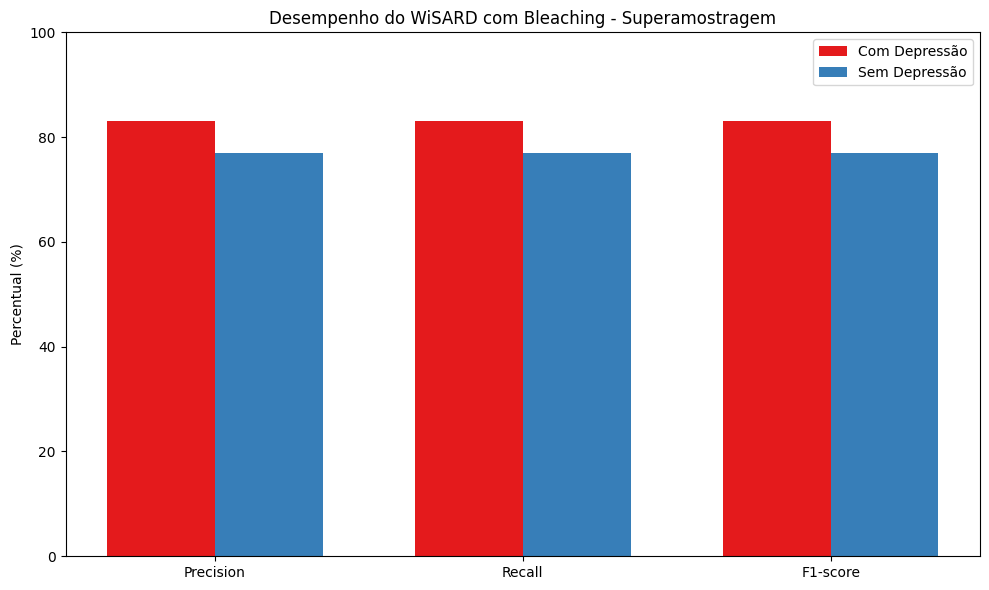

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados das métricas (sem Accuracy)
metrics = ["Precision", "Recall", "F1-score"]
values_com_depressao = [83.00, 83.00, 83.00]  # Substitua pelos valores reais
values_sem_depressao = [77.00, 77.00, 77.00] # Substitua pelos valores reais

# Configuração do gráfico
x = np.arange(len(metrics))  # Posições no eixo X
width = 0.35  # Largura das barras

plt.figure(figsize=(10, 6))

# Plotar as barras
plt.bar(x - width/2, values_com_depressao, width, label="Com Depressão", color='#e41a1c')
plt.bar(x + width/2, values_sem_depressao, width, label="Sem Depressão", color='#377eb8')

# Personalização do gráfico
plt.title("Desempenho do WiSARD com Bleaching - Superamostragem")
plt.ylabel("Percentual (%)")
plt.ylim(0, 100)
plt.xticks(x, metrics)
plt.legend()

# Exibir gráfico
plt.tight_layout()
plt.show()

# TÉCNICA HÍBRIDA

Antes:  Counter({1: 12292, 0: 8618})
Depois:  Counter({0: 8145, 1: 7558})
-------------------------------
Teste Accuracy: 80.30%
Teste de superamostragem - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2936
           1       0.87      0.77      0.82      4034

    accuracy                           0.80      6970
   macro avg       0.80      0.81      0.80      6970
weighted avg       0.81      0.80      0.80      6970

-------------------------------
Training Accuracy: 95.98%
Training Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8145
           1       0.97      0.95      0.96      7558

    accuracy                           0.96     15703
   macro avg       0.96      0.96      0.96     15703
weighted avg       0.96      0.96      0.96     15703



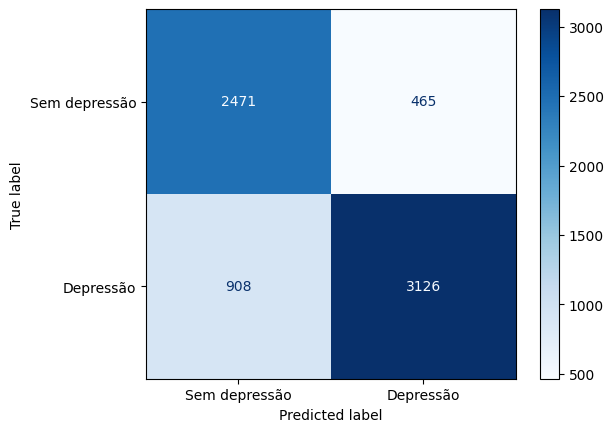

In [2]:
import os
import sys
import csv
import numpy as np
import pandas as pd
from encoders import process_input, ThermometerEncoder, CodeWord
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from typing import List, Dict
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings

# Filtrar warnings de futuros relacionados ao scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# Implementação das classes RAM, Discriminator, Bleaching e WiSARD
class RAM:
    def __init__(self, indexes: List[int] = None):
        self.addresses = indexes if indexes else []
        self.positions: Dict[int, int] = {}

    def get_vote(self, input_data: List[int]) -> int:
        index = self.get_index(input_data)
        return self.positions.get(index, 0)

    def train(self, input_data: List[int]):
        index = self.get_index(input_data)
        self.positions[index] = self.positions.get(index, 0) + 1

    def get_index(self, input_data: List[int]) -> int:
        index = 0
        p = 1
        for addr in self.addresses:
            bit = input_data[addr]
            index += bit * p
            p *= 2
        return index

class Discriminator:
    def __init__(self, address_size: int, entry_size: int):
        self.entry_size = entry_size
        self.rams: List[RAM] = []
        self.set_ram_shuffle(address_size)

    def classify(self, input_data: List[int]) -> List[int]:
        return [ram.get_vote(input_data) for ram in self.rams]

    def train(self, input_data: List[int]):
        for ram in self.rams:
            ram.train(input_data)

    def set_ram_shuffle(self, address_size: int):
        num_rams = self.entry_size // address_size
        remain = self.entry_size % address_size
        indexes = list(range(self.entry_size))
        np.random.shuffle(indexes)

        self.rams = []
        for i in range(num_rams):
            sub_indexes = indexes[i * address_size:(i + 1) * address_size]
            self.rams.append(RAM(sub_indexes))

class Bleaching:
    @staticmethod
    def make(all_votes: List[List[int]]) -> List[int]:
        labels = [0, 0]
        bleaching = 1
        while True:
            for i in range(2):
                labels[i] = sum(1 for vote in all_votes[i] if vote >= bleaching)
            bleaching += 1
            biggest = max(labels)
            if labels.count(biggest) == 1 or biggest <= 1:
                break
        return labels

class WiSARD:
    def __init__(self, address_size: int, input_size: int):
        self.address_size = address_size
        self.discriminators = [
            Discriminator(address_size, input_size),
            Discriminator(address_size, input_size)
        ]

    def train(self, input_data: List[int], label: int):
        self.discriminators[label].train(input_data)

    def classify(self, input_data: List[int]) -> int:
        candidates = self.classify2(input_data)
        return 0 if candidates[0] >= candidates[1] else 1

    def classify2(self, input_data: List[int]) -> List[int]:
        all_votes = [
            self.discriminators[0].classify(input_data),
            self.discriminators[1].classify(input_data)
        ]
        return Bleaching.make(all_votes)

# Função para binarizar o dataset
def binarize_column(column_name, value):
    """
    Função para realizar a binarização de acordo com o valor da coluna.
    Retorna uma string que representa o valor binarizado.
    """
    if column_name == "Gender":
        return "10" if value == "Male" else "01"
    elif column_name == "Age":
        thermometer = ThermometerEncoder(minimum=18, maximum=59, resolution=4)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "Profession":
        if value == "Architect":
            return "1000000000000000"
        elif value == "Chef":
            return "0100000000000000"
        elif value == "Civil Engineer":
            return "0010000000000000"
        elif value == "Content Writer":
            return "0001000000000000"
        elif value == "Civil Engineer":
            return "0000100000000000"
        elif value == "Digital Marketer":
            return "0000010000000000"
        elif value == "Doctor":
            return "0000001000000000"
        elif value == "Civil Engineer":
            return "0000000100000000"
        elif value == "Educational Consultant":
            return "0000000010000000"
        elif value == "Entrepreneur":
            return "0000000001000000"
        elif value == "Lawyer":
            return "0000000000100000"
        elif value == "Manager":
            return "0000000000010000"
        elif value == "Pharmacist":
            return "0000000000001000"
        elif value == "Student":
            return "0000000000000100"
        elif value == "Teacher":
            return "0000000000000010"
        elif value == "UX/UI Designer":
            return "0000000000000001"
    elif column_name == "AcademicPressure":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "WorkPressure":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=4)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "GPA":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=10.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "StudySatisfaction":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=5.0, resolution=3)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "JobSatisfaction":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=4.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "SleepDuration":
        if value == "5-6 hours":
            return "0100"  # Menor ênfase
        elif value == "Less than 5 hours":
            return "1110"  # Maior ênfase para pouco sono
        elif value == "7-8 hours":
            return "0010"  # Menor ênfase (normal)
        elif value == "More than 8 hours":
            return "0111"  # Maior ênfase para muito sono
    elif column_name == "DietaryHabits":
        if value == "Healthy":
            return "0100"
        elif value == "Unhealthy":
            return "1110"
        elif value == "Moderate":
            return "0010"
        elif value == "Others":
            return "0001"
    elif column_name == "SuicidalThoughts":
        if value == "Yes":
            return "111111111111"
        elif value == "No":
            return "000000000000"
    elif column_name == "WorkStudyHours":
        thermometer = ThermometerEncoder(minimum=0.0, maximum=12.0, resolution=10)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))
    elif column_name == "FinancialsStress":
        thermometer = ThermometerEncoder(minimum=1.0, maximum=5.0, resolution=8)
        encoded_value = thermometer.encode(value)  # Realiza a codificação
        return ''.join(map(str, encoded_value))  # Converte a lista ou array em uma única string
    elif column_name == "FamilyMentalIllness":
        if str(value) == "Yes":
            return "111111111111"
        elif str(value) == "No":
            return "000000000000"

train_data = []  # Lista para armazenar os dados binarizados
train_labels = [] # Lista para armazenar os rótulos dos dados

def binarize_dataset(input_file):
    """
    Lê um arquivo .csv, binariza cada linha e salva em um novo arquivo.
    """
    # Colunas que queremos processar
    columns_to_process = [
        "Gender", "Age", "Profession", "AcademicPressure", "WorkPressure", "GPA",
        "StudySatisfaction", "JobSatisfaction", "SleepDuration", "DietaryHabits",
        "SuicidalThoughts", "WorkStudyHours", "FinancialsStress", "FamilyMentalIllness"
    ]

    # Lendo o arquivo de entrada
    df = pd.read_excel(input_file)

    # Processando as linhas
    binary_representations = []
    for _, row in df.iterrows():
        binary_representation = ""
        for column in columns_to_process:
            binary_representation += binarize_column(column, row[column])
        train_data.append(list(map(int, binary_representation)))
        train_labels.append(1 if row["Depression"] == 1 else 0)  # Rótulos como inteiros
        #train_labels.append("depressao" if row["Depression"] == 1 else "sem_depressao")  # Adiciona rótulo em formato de strings

    return train_data, train_labels

# Função principal para o dataset de depressão
def main():
    # Substitua sys.argv por parâmetros diretos
    input_file = "/content/drive/MyDrive/RedesNeurais-Conteudos/TrabalhoFinal/Final_Student depression - Domingo.xlsx"  # Substitua pelo caminho do seu arquivo Excel
    train_data, train_labels = binarize_dataset(input_file)
    address_size = 9  # Substitua pelo tamanho desejado do endereço

    input_size = len(train_data[0])
    wisard = WiSARD(address_size, input_size)

    # Dividir o dataset em treino e teste usando train_test_split
    SEED = 42
    np.random.seed(SEED)
    # Divisão do dataset em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.25, random_state=SEED)

    # definindo a estratégia de reamostragem
    sample = SMOTEENN(sampling_strategy=1)

    # aplicando a transformação de reamostragem
    X_sample, Y_sample = sample.fit_resample(X_train, y_train)

    # exibindo a distribuição de classes
    print("Antes: ", Counter(y_train))
    print("Depois: ", Counter(Y_sample))

    # Treinamento
    for input_data, label in zip(X_sample, Y_sample):
        wisard.train(input_data, label)

    # Teste
    bt_balanced_predicted_wd = [wisard.classify(x) for x in X_test]

    print("-------------------------------")
    # Cálculo das métricas
    accuracy = accuracy_score(y_test, bt_balanced_predicted_wd)
    print(f"Teste Accuracy: {accuracy:.2%}")
    print("Teste de superamostragem - Classification Report:")
    print(classification_report(y_test, bt_balanced_predicted_wd))

    # Teste no conjunto de treino
    y_train_pred = [wisard.classify(x) for x in X_sample]
    print("-------------------------------")

    # Métricas do conjunto de treino
    train_accuracy = accuracy_score(Y_sample, y_train_pred)
    print(f"Training Accuracy: {train_accuracy:.2%}")
    print("Training Classification Report:")
    print(classification_report(Y_sample, y_train_pred))

    # Gerar a matriz de confusão
    cm = confusion_matrix(y_test, bt_balanced_predicted_wd)

    # Plotar a matriz de confusão
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sem depressão", "Depressão"])
    disp.plot(cmap="Blues")
    #######################

# Execute a função diretamente
main()


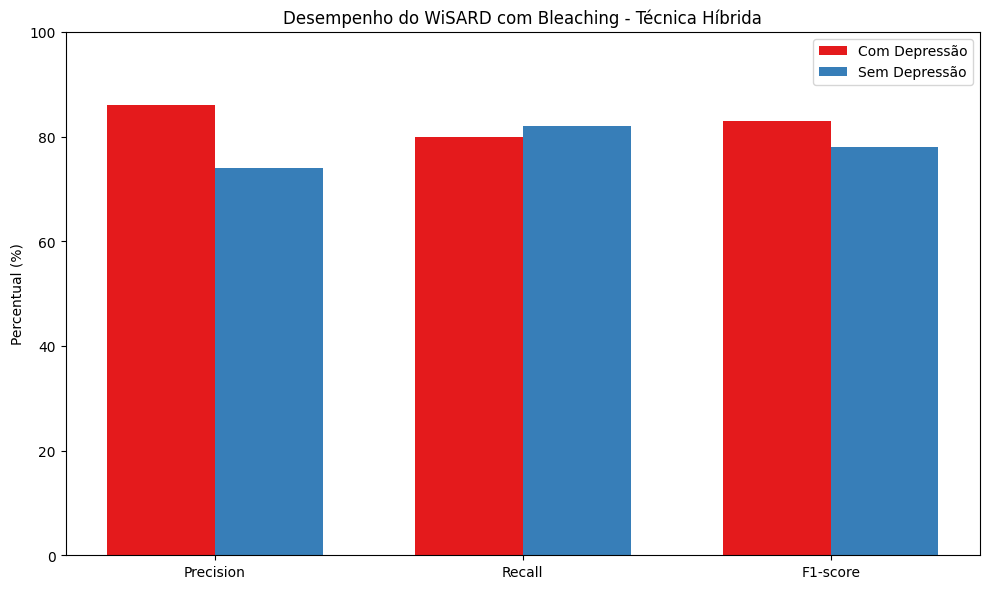

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados das métricas (sem Accuracy)
metrics = ["Precision", "Recall", "F1-score"]
values_com_depressao = [86.00, 80.00, 83.00]  # Substitua pelos valores reais
values_sem_depressao = [74.00, 82.00, 78.00]  # Substitua pelos valores reais

# Configuração do gráfico
x = np.arange(len(metrics))  # Posições no eixo X
width = 0.35  # Largura das barras

plt.figure(figsize=(10, 6))

# Plotar as barras
plt.bar(x - width/2, values_com_depressao, width, label="Com Depressão", color='#e41a1c')
plt.bar(x + width/2, values_sem_depressao, width, label="Sem Depressão", color='#377eb8')

# Personalização do gráfico
plt.title("Desempenho do WiSARD com Bleaching - Técnica Híbrida")
plt.ylabel("Percentual (%)")
plt.ylim(0, 100)
plt.xticks(x, metrics)
plt.legend()

# Exibir gráfico
plt.tight_layout()
plt.show()